In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#モデルと損失関数の定義, テスト時はスコアの確認
def reLu(z):
    return np.maximum(0, z)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def model2(data_x,G, W, A, b,y,test =False):
        
        V = len(G[0]) #ノード数
        D = len(data_x[0])#頂点の次元
        
        a1 =np.zeros([V,D])#各要素の隣接値の和
        f1 =np.zeros([V,D])#各活性化関数の値
        a2 =np.zeros([V,D])
        f2 =np.zeros([V,D])
        a3 =np.zeros([V,D])
        f3 =np.zeros([V,D])
        set_id = [] #隣接ノードのindex集合.
        for i in range(0, V):
            set_id .append([G_id for G_id, element in enumerate(G[i]) if element == 1])#ノードi　の隣接idを格納
            a1[i] = np.sum(data_x[set_id[i]] , axis=0)
            f1[i] =  reLu(np.dot(W,a1[i]))
        for i in range(0, V):   
            a2[i] = np.sum(f1[set_id[i]] , axis=0)
            f2[i] =  reLu(np.dot(W,a2[i]))
        for i in range(0, V):
            a3[i] = np.sum(f2[set_id[i]] , axis=0)
            f3[i] =  reLu(np.dot(W,a3[i]))    
        h = np.sum(f3, axis=0)
        s = np.dot(A,h)+b
        
        if (test ==False):
            #損失関数
            loss =  y*np.log(1+np.exp(-s)+1e-4) +(1-y)*np.log(1+np.exp(s)+1e-4)
            
        elif(test ==True):
            if(sigmoid(s)>0.5):
                loss = 1- y
            else:
                loss = abs(0 - y)
        return loss

In [3]:
#データの読み込み
train_graph, train_value, train_label= [],[],[]
test_graph, test_value,test_label  = [],[],[]
training_size = 1500
validation_size =500
train_indicate = np.arange(training_size) #ミニバッチのデータシャッフルに使用する番号.
node_dim = 8 #ノードの次元

for i in range(2000):
    if (i<training_size):#学習データの読み込み
        train_graph.append(np.loadtxt('datasets/train/{}_graph.txt'.format(i), skiprows=1))#グラフ隣接行列データを読み込む.
        dim = np.loadtxt('datasets/train/{}_graph.txt'.format(i), usecols=0)[0]#グラフのノードの数
        train_label.append(np.loadtxt('datasets/train/{}_label.txt'.format(i)) )#ラベルを格納
        a =  [0] * int(dim)
        a_one_hot = np.identity(node_dim)[a] # 初期の特徴ベクトル
        train_value.append(a_one_hot)
        
    else:#評価データの読み込み
        test_graph.append(np.loadtxt('datasets/train/{}_graph.txt'.format(i), skiprows=1))#グラフ隣接行列データを読み込む.   
        dim = np.loadtxt('datasets/train/{}_graph.txt'.format(i), usecols=0)[0]#グラフのノードの数
        test_label.append(np.loadtxt('datasets/train/{}_label.txt'.format(i)) )#ラベルを格納
        a =  [0] * int(dim) 
        a_one_hot = np.identity(node_dim)[a] # 初期の特徴ベクトル
        test_value.append(a_one_hot)    

In [15]:
"""SGD実装"""
batch_size = 125
epoch =20
training_loss,training_fault = [],[]
validation_loss, validation_fault= [],[]
loss_sum =0 

epsilon =0.001 # 数値微分の更新幅
alpha = 0.01 #学習率

#モデルパラメータの初期化
np.random.seed(seed=20)
W = np.random.normal(0,0.4,(node_dim, node_dim))
A = np.random.normal(0,0.4,node_dim)
b = 0.

loss_Grad_W = np.zeros(W.size)#W勾配の格納
loss_Grad_A = np.zeros(A.size) #A勾配の格納
loss_Grad_b = 0                           #b勾配の格納

Delta = np.zeros([W[0].size,W[0].size]) #Wの勾配計算のためのDelacのDelta関数を表現する行列
Delta2 = np.zeros(A.size) #Aの勾配計算のためのDelacのDelta関数を表現する行列

for epoc in range(epoch):
    np.random.shuffle(train_indicate)
    start = time.time()
    for i in range(training_size ):#ミニバッチの計算
        
        for j in range(W.size):#WのGradient
            Delta[int(j/W[0].size), int(j%W[0].size)] = epsilon 
            loss_Grad_W[j] += (model2(train_value[train_indicate[i]],train_graph[train_indicate[i]], W+Delta, A, b, train_label[train_indicate[i]]) - model2(train_value[train_indicate[i]],train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
            Delta[int(j/W[0].size), int(j%W[0].size)] = 0 
            
        for k in range(A.size): #AのGradient
            Delta2[k] = epsilon
            loss_Grad_A[k] +=  (model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A+Delta2, b, train_label[train_indicate[i]] ) - model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
            Delta2[k] = 0 
        #bのGradient
        loss_Grad_b += (model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b+epsilon, train_label[train_indicate[i]]) - model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
        #Lossの合計
        loss_sum += model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]])
        if( (i+1)%batch_size ==0):#バッチサイズの大きさになったら勾配の更新     
            W = W -  alpha*np.reshape(loss_Grad_W, [W[0].size, W[0].size])/batch_size
            A = A -  alpha*loss_Grad_A/batch_size
            b = b  -  alpha*loss_Grad_b/batch_size
            
            loss_Grad_W = np.zeros([W.size])
            loss_Grad_A = np.zeros([A.size])
            loss_Grad_b = 0
            
    #学習データの平均損失
    training_loss.append(loss_sum/training_size)
    loss_sum= 0
    #学習データの予測性能
    precure = 0
    for p in range(training_size):
        precure += model2(train_value[p], train_graph[p], W, A, b, train_label[p], True)
    training_fault.append((training_size - precure) /training_size)
    
     #評価データの予測性能と平均損失
    precure = 0   
    for l in range(validation_size):
        precure += model2(test_value[l], test_graph[l], W, A, b, test_label[l], True)
        loss_sum += model2(test_value[l], test_graph[l], W, A, b, test_label[l])
    validation_loss.append(loss_sum/validation_size)
    validation_fault.append((validation_size - precure) /validation_size)
    loss_sum= 0
    
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")    
    

elapsed_time:97.73802018165588[sec]
elapsed_time:96.82100868225098[sec]
elapsed_time:98.02714681625366[sec]
elapsed_time:97.7047324180603[sec]
elapsed_time:97.25155329704285[sec]
elapsed_time:97.6408371925354[sec]
elapsed_time:96.27737736701965[sec]
elapsed_time:96.96778869628906[sec]
elapsed_time:96.66407752037048[sec]
elapsed_time:96.35175061225891[sec]
elapsed_time:96.72764372825623[sec]
elapsed_time:97.47113800048828[sec]
elapsed_time:97.54585862159729[sec]
elapsed_time:100.00076174736023[sec]
elapsed_time:98.74559354782104[sec]
elapsed_time:97.05315709114075[sec]
elapsed_time:96.56003880500793[sec]
elapsed_time:96.66343283653259[sec]
elapsed_time:96.08482241630554[sec]
elapsed_time:97.37075114250183[sec]


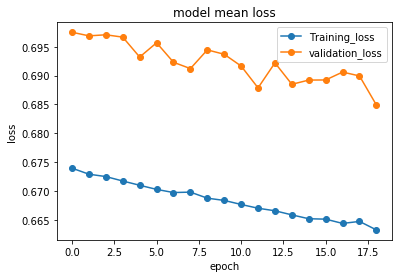

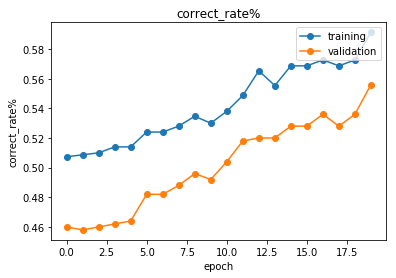

In [17]:
# 損失の履歴をプロット
plt.plot(training_loss,"o-",label="Training_loss") #Training 平均損失
plt.plot(validation_loss,"o-", label="validation_loss")#validation 平均損失
plt.title('model mean loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()
# 正答率の履歴をプロット
plt.plot(training_fault,"o-",label="training") #Training 正答率
plt.plot(validation_fault,"o-",label="validation") #validation 正答率
plt.title('correct_rate%')
plt.xlabel('epoch')
plt.ylabel('correct_rate%')
plt.legend(loc='upper right')
plt.show()

In [10]:
"""momentum SGD実装"""

batch_size = 125
epoch =20
training_loss,training_fault = [],[]
validation_loss, validation_fault= [],[]

loss_sum =0 # 各バッチごとの損失の合計
epsilon =0.001 #数値微分のパラメータ
alpha = 0.001 #学習率
eta =0.9 #mormentum率

#モデルパラメータ初期値
np.random.seed(seed=20)
W = np.random.normal(0,0.4,(node_dim,node_dim))
A = np.random.normal(0,0.4,node_dim)
b = 0.

update_W = np.zeros([W.size])  #W更新幅の初期値
update_A = np.zeros([A.size])   #A更新幅の初期値
update_b = 0                                #b更新幅の初期値

loss_Grad_W = np.zeros(W.size)#W勾配の格納
loss_Grad_A = np.zeros(A.size) #A勾配の格納
loss_Grad_b = 0                           #b勾配の格納

Delta = np.zeros([W[0].size,W[0].size]) #Wの勾配計算のためのDelacのDelta関数を表現する行列
Delta2 = np.zeros(A.size) #Aの勾配計算のためのDelacのDelta関数を表現する行列

for epoc in range(epoch):
    np.random.shuffle(train_indicate)
    start = time.time()
    for i in range(training_size):
        
        for j in range(W.size):#WのGradientの計算
            Delta[int(j/W[0].size), int(j%W[0].size)] = epsilon 
            loss_Grad_W[j] += (model2(train_value[train_indicate[i]],train_graph[train_indicate[i]], W+Delta, A, b, train_label[train_indicate[i]]) - model2(train_value[train_indicate[i]],train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
            Delta[int(j/W[0].size), int(j%W[0].size)] = 0 
            
        for k in range(A.size): #AのGradientの計算
            Delta2[k] = epsilon
            loss_Grad_A[k] +=  (model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A+Delta2, b, train_label[train_indicate[i]] ) - model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
            Delta2[k] = 0 
            
        #bのGradientの計算
        loss_Grad_b += (model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b+epsilon, train_label[train_indicate[i]]) - model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]]))/epsilon
            
        loss_sum += model2(train_value[train_indicate[i]], train_graph[train_indicate[i]], W, A, b, train_label[train_indicate[i]])#minibatch内のLossの合計
        if( (i+1)%batch_size ==0 ):
            #バッチサイズの大きさになったら勾配の更新     
            W = W - alpha*np.reshape(loss_Grad_W, [W[0].size, W[0].size])/batch_size + eta*np.reshape(update_W,[W[0].size,W[0].size])
            A = A - alpha*loss_Grad_A/batch_size + eta*update_A
            b = b - alpha*loss_Grad_b/batch_size + eta*update_b
            #update_{W,A,b}
            update_W =  -  alpha*loss_Grad_W/batch_size + eta*update_W
            update_A = - alpha*loss_Grad_A/batch_size + eta*update_A
            update_b = - alpha*loss_Grad_b/batch_size + eta*update_b
    
            loss_Grad_W = np.zeros([W.size])
            loss_Grad_A = np.zeros([A.size])
            loss_Grad_b = 0
            
    #学習データの平均損失
    training_loss.append(loss_sum/training_size)
    loss_sum= 0
    #学習データの予測性能
    precure = 0
    for p in range(training_size):
        precure += model2(train_value[p], train_graph[p], W, A, b, train_label[p], True)
    training_fault.append((training_size - precure) /training_size)
    
     #評価データの予測性能と平均損失
    precure = 0   
    for l in range(validation_size):
        precure += model2(test_value[l], test_graph[l], W, A, b, test_label[l], True)
        loss_sum += model2(test_value[l], test_graph[l], W, A, b, test_label[l])
    validation_loss.append(loss_sum/validation_size)
    validation_fault.append((validation_size - precure) /validation_size)
    loss_sum= 0
    
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")  

elapsed_time:100.26459574699402[sec]
elapsed_time:99.72785139083862[sec]
elapsed_time:99.62071013450623[sec]
elapsed_time:101.64681267738342[sec]
elapsed_time:101.47574186325073[sec]
elapsed_time:100.59767460823059[sec]
elapsed_time:101.23585319519043[sec]
elapsed_time:101.5386917591095[sec]
elapsed_time:101.10710120201111[sec]
elapsed_time:101.20808625221252[sec]
elapsed_time:100.54774475097656[sec]
elapsed_time:100.66663646697998[sec]
elapsed_time:99.23667359352112[sec]
elapsed_time:98.13671851158142[sec]
elapsed_time:100.2568531036377[sec]
elapsed_time:101.00791645050049[sec]
elapsed_time:101.53977036476135[sec]
elapsed_time:100.88788342475891[sec]
elapsed_time:100.71513032913208[sec]
elapsed_time:101.29809856414795[sec]


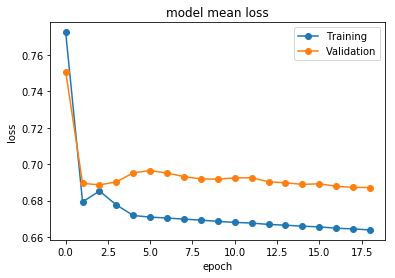

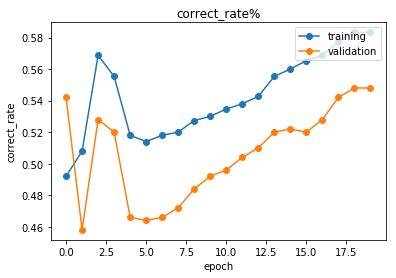

In [12]:
# 損失の履歴をプロット
plt.plot(training_loss[1:],"o-",label="Training") #Training 平均損失
plt.plot(validation_loss[1:],"o-", label="Validation")#validation 平均損失
plt.title('model mean loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()
# 正答率の履歴をプロット
plt.plot(training_fault,"o-",label="training") #Training 正答率
plt.plot(validation_fault,"o-",label="validation") #validation 正答率
plt.title('correct_rate%')
plt.xlabel('epoch')
plt.ylabel('correct_rate')
plt.legend(loc='upper right')
plt.show()